<a href="https://colab.research.google.com/github/Abhishekjain113/Breast_cancer_dictation_CNN/blob/main/Breast_cancer_desenet_121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [ ]:
classes_types=['M', 'B','N']
data_dir = '//content/drive/MyDrive/Internship/Breast_Cancer_Dataset'
train_dir = os.path.join(data_dir)

     

In [ ]:
train_data = []
for defects_id, sp in enumerate(classes_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'Class ID','Class Type'])
train.head()


,File,Class ID,Class Type
0,M/mdb124.pgm,0,M
1,M/mdb117.pgm,0,M
2,M/mdb115.pgm,0,M
3,M/mdb058.pgm,0,M
4,M/mdb095.pgm,0,M


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()
     

,File,Class ID,Class Type
0,N/mdb108.pgm,2,N
1,N/mdb003.pgm,2,N
2,N/mdb122.pgm,2,N
3,M/mdb075.pgm,0,M
4,B/mdb165.pgm,1,B


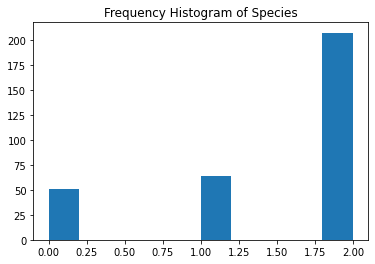

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.hist(train['Class ID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

M type image


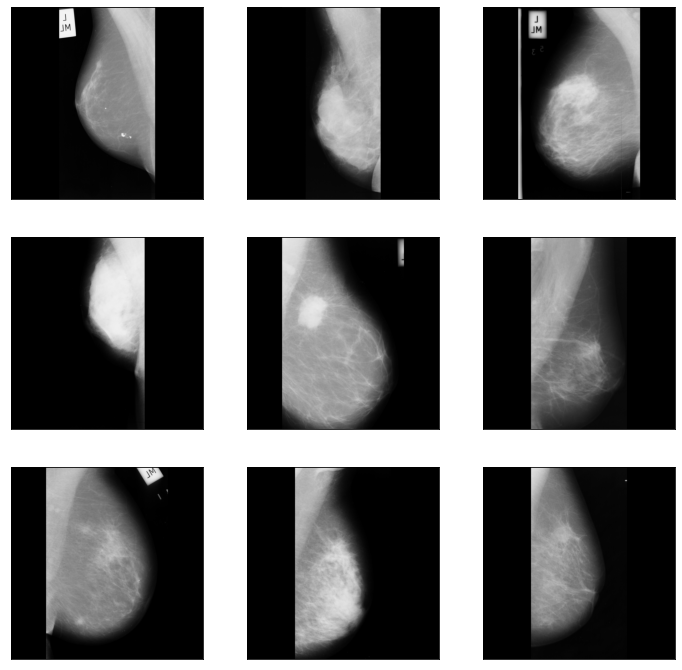

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Class Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

print('M type image')
plot_defects('M', 3, 3)



N type image


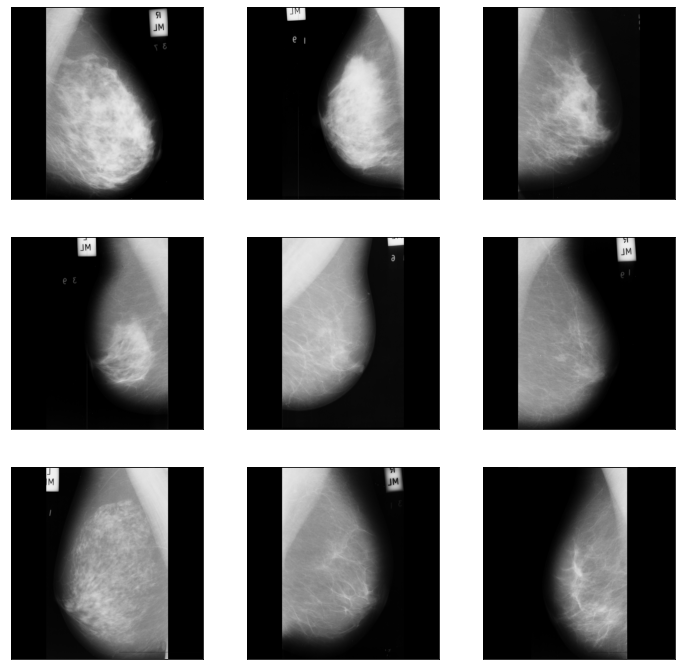

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Class Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

print('N type image')
plot_defects('N', 3, 3)

B type image


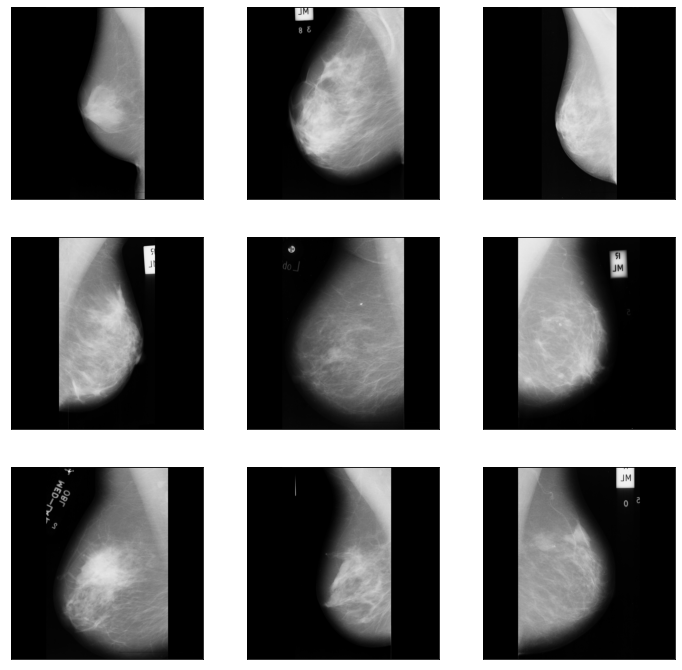

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Class Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
print('B type image')
plot_defects('B', 3, 3)



In [ ]:

IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
    

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

322it [00:42,  7.58it/s]

Train Shape: (322, 64, 64, 3)


In [ ]:
Y_train = train['Class ID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [ ]:
BATCH_SIZE = 64
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [ ]:
EPOCHS = 25
SIZE=64
N_ch=3

def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=100,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))
     

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 7,305,879
Trainable params: 7,219,671
Non-trainable params: 86,208
_________________________________________________________________


<ipython-input-15-97441cba5172>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.24083, saving model to model.h5
4/4 - 43s - loss: 2.2642 - accuracy: 0.2798 - val_loss: 1.2408 - val_accuracy: 0.6000 - lr: 0.0020 - 43s/epoch - 11s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.24083 to 1.22342, saving model to model.h5
4/4 - 17s - loss: 1.9845 - accuracy: 0.3368 - val_loss: 1.2234 - val_accuracy: 0.5846 - lr: 0.0020 - 17s/epoch - 4s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.22342 to 1.18303, saving model to model.h5
4/4 - 17s - loss: 1.8902 - accuracy: 0.3886 - val_loss: 1.1830 - val_accuracy: 0.6308 - lr: 0.0020 - 17s/epoch - 4s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.18303 to 1.17158, saving model to model.h5
4/4 - 17s - loss: 1.9274 - accuracy: 0.3782 - val_loss: 1.1716 - val_accuracy: 0.5692 - lr: 0.0020 - 17s/epoch - 4s/step
Epoch 5/100

Epoch 5: val_loss improved from 1.17158 to 1.12609, saving model to model.h5
4/4 - 17s - loss: 1.8542 - accuracy: 0.4041 - val_loss: 1.1261 - val_

3/3 [==============================] - 1s 407ms/step


Text(0.5, 145.31999999999996, 'Predicted')

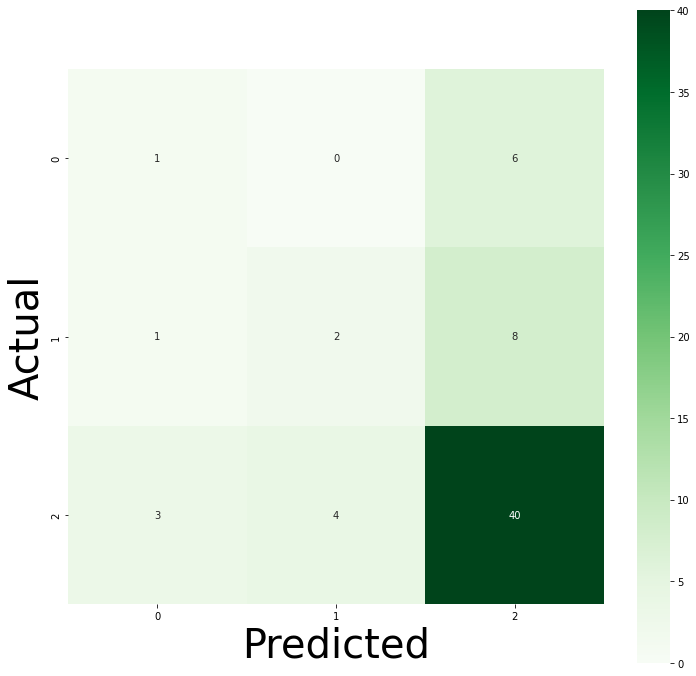

In [24]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

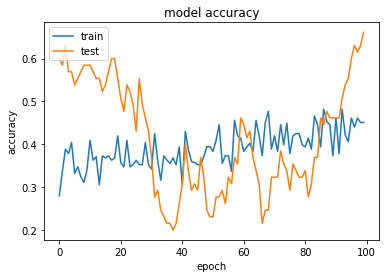

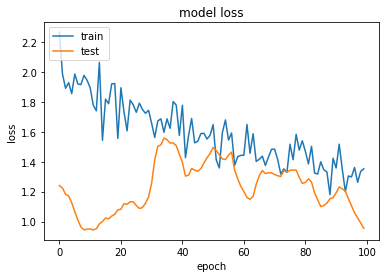

In [25]:

# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 91ms/step
[0.09086134 0.11022006 0.7989186 ]


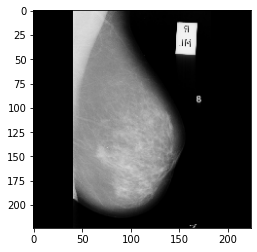

Prediction: N


In [27]:
from skimage import io
#path='imbalanced/Scratch/Scratch_400.jpg'
import keras.utils as image

img = image.load_img('//content/drive/MyDrive/Internship/Breast_Cancer_Dataset/M/mdb058.pgm', grayscale=False, target_size=(64, 64))
show_img=image.load_img('//content/drive/MyDrive/Internship/Breast_Cancer_Dataset/M/mdb058.pgm', grayscale=False, target_size=(224, 224))
disease_class=['M','B','N']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])